<a href="https://colab.research.google.com/github/dannynacker/roX_gen/blob/main/roX_omni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following notebook contains two main scripts, with scripts following the primary duo being used to apply various smoothing techniques over the sessions to introduce gradual onset and decay.

The final script allows for user input to specify session duration in seconds, dwell time (i.e., step time) and whether or not a Gaussian envelope should be applied across parameters over the entire length of the session to encourage more gradual onset and offset; thus, you may find more value in messing around with the final script in this notebook compared to the first scripts.

Both scripts produce plots of each session as well as .txt files that are formatted to be read by the device, featuring one oscillator utilizing all 4 LEDs.

The first script generates 5 separate sessions based on different resonance dynamics. Each time the script is ran, these sessions will be produced slightly differently, unless a seed is specified.

All sessions generated remain within the parameters set by WP1. These parameters include:

**Luminance:** 10-100 %

**Frequency:** 3-15 Hz

**Duty Cycle:** 25-75 %

Restraints in the intensity of parameter shifts are also put in place per WP1:

**Luminance Shifts:** No more than 20% at a time

**Frequency Shifts:** No greater than 2.2x at a time

**Duty Cycle Shifts:** No more than 25% at a time

However, these restraints correspond to the granularity of this sequence generator -- 100 ms steps -- which may not perfectly reflect the capacity of shift intensity explored by WP1.

Each of the 5 sessions is built using different resonance logic.

**1. HG (Harmonic Glide)**

Frequency increases linearly across our range, with slight noise. Luminance and duty cycle modulate sinusoidally over time for smooth changes. In short, frequency rises over time, with rhythmic changes in luminance and duty cycle.

**2. OM (Ocillatory Mode)**

Frequency oscillates around 9 Hz, but with +- 3 Hz periodic shifts. Luminance and duty cycle modulate sinuosidally, but at a faster rate than in HG. In short, all parameters remain cyclic and structured throughout the session.

**3. DP (Divergent Pattern)**

Frequency is modulated by small multiplicative patterns around the previous value, ensuring all values remain relative to each other over time. Luminance and duty cycle, however, feature randomized jumps, increasing unpredictability. In short, while structured in some aspects, this session is also semi-random.  

**4. CP (Chirped Excitation)**

Frequency accelerates rapidly (like a chirp). Luminance and duty cycle gradually increase according to a power-law curve. In short, this session ramps up over time, with exponential growth across the session.

**5. RE (Randomized Exploration)**

All parameters are randomized at each step while remaining within the set range.

The second scripts takes a designated 60 seconds from each generated session in a specified order and appends them into an "omni-session" in which the specific characteristics of each generation logic can be more directly compared to each other to aid in further fine-tuning of session parameters.

Further updates will include a more dynamic creation of "omni" based on specific user input parameters.

1. 5 Individual Square-Wave Sessions

Session files generated and saved.


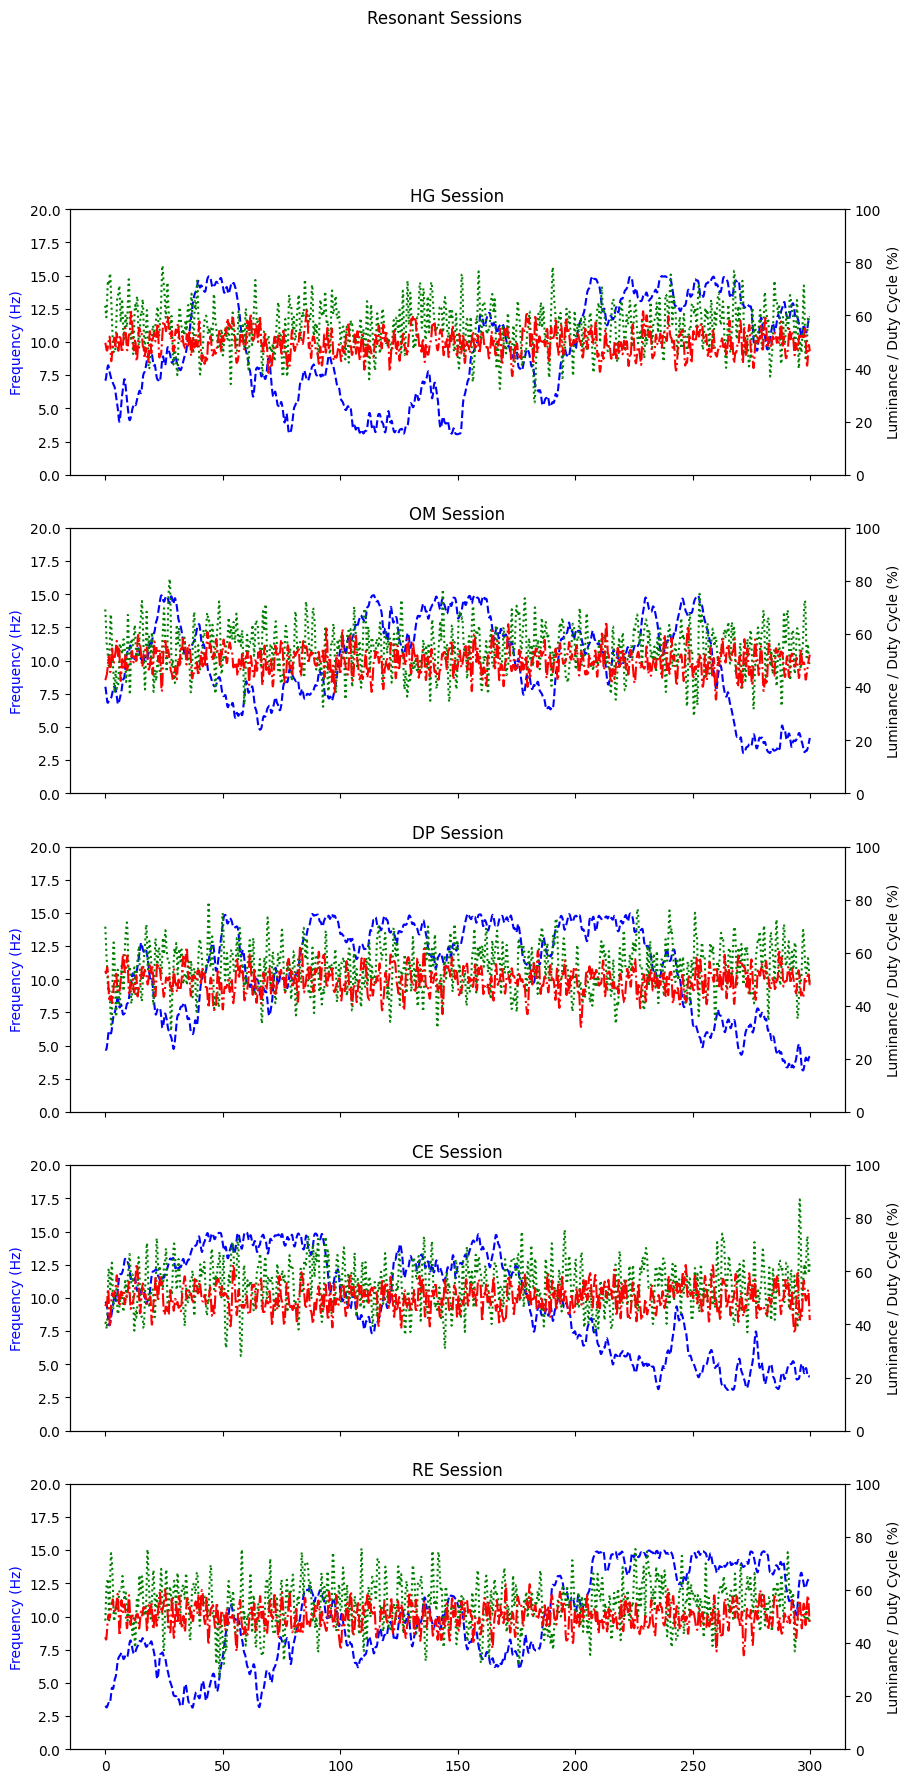

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ===========================
# Session Parameters
# ===========================
session_duration = 300  # 5 minutes (300 seconds)
time_step = 0.1  # 0.1s resolution
num_steps = int(session_duration / time_step)

# Parameter constraints
frequency_range = (3, 15)  # Hz
luminance_range = (10, 100)  # Arbitrary units (Integers)
duty_cycle_range = (25, 75)  # Percentage (Integers)
max_duty_jump = 25  # Max duty cycle change per step
max_luminance_jump = 20  # Max luminance change per step
max_freq_jump = 1.2  # Constrain frequency changes but allow variation
smoothing_sigma = 3  # **Used for visualization only!**

# ===========================
# Directory Setup
# ===========================
output_dir = "session_data"
stp_dir = "stp_sessions"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(stp_dir, exist_ok=True)

# ===========================
# Modulation Functions
# ===========================

def modulate_frequency(prev_freq, progress, mode):
    """Generate frequency variation dynamically based on mode."""
    if mode == "harmonic_glide":
        freq = 3 + (12 * progress) + np.random.uniform(-0.5, 0.5)
    elif mode == "oscillatory_mode":
        freq = 9 + 3 * np.sin(2 * np.pi * progress) + np.random.uniform(-0.2, 0.2)
    elif mode == "divergent_pattern":
        freq = prev_freq * (1 + np.random.uniform(-0.1, 0.1))
    elif mode == "chirped_excitation":
        freq = 3 + (10 * (progress ** 1.5)) + np.random.uniform(-0.3, 0.3)
    elif mode == "randomized_exploration":
        freq = np.random.uniform(*frequency_range)
    else:
        freq = prev_freq + np.random.uniform(-0.5, 0.5)

    freq = np.clip(freq, prev_freq / max_freq_jump, prev_freq * max_freq_jump)
    freq = np.clip(freq, *frequency_range)
    return freq

def modulate_luminance(progress, prev_lum, mode):
    """Generate distinct luminance patterns per session while enforcing integer constraints."""
    if mode == "harmonic_glide":
        target = 20 + (80 * np.sin(progress * np.pi * 0.5)) + np.random.randint(-5, 6)
    elif mode == "oscillatory_mode":
        target = 10 + (90 * (0.5 + 0.5 * np.sin(6 * np.pi * progress))) + np.random.randint(-8, 9)
    elif mode == "divergent_pattern":
        target = np.random.randint(10, 101) if np.random.rand() < 0.3 else prev_lum + np.random.randint(-20, 21)
    elif mode == "chirped_excitation":
        target = 10 + (90 * (progress ** 1.4)) + np.random.randint(-5, 6)
    elif mode == "randomized_exploration":
        target = np.random.randint(10, 101)
    else:
        target = np.random.randint(10, 101)

    return int(np.clip(target, *luminance_range))

def modulate_duty_cycle(progress, prev_duty, mode):
    """Generate distinct duty cycle variations per session while ensuring smooth transitions."""
    if mode == "harmonic_glide":
        target = 30 + (40 * np.sin(progress * np.pi * 0.5)) + np.random.randint(-3, 4)
    elif mode == "oscillatory_mode":
        target = 25 + (50 * (0.5 + 0.5 * np.sin(8 * np.pi * progress))) + np.random.randint(-6, 7)
    elif mode == "divergent_pattern":
        target = np.random.randint(25, 76) if np.random.rand() < 0.3 else prev_duty + np.random.randint(-15, 16)
    elif mode == "chirped_excitation":
        target = 25 + (50 * (progress ** 1.3)) + np.random.randint(-5, 6)
    elif mode == "randomized_exploration":
        target = np.random.randint(25, 76)
    else:
        target = np.random.randint(25, 76)

    return int(np.clip(target, *duty_cycle_range))

# ===========================
# Generate Sessions
# ===========================

def generate_sequence(mode):
    time = np.arange(0, session_duration, time_step)
    num_steps = len(time)

    frequency = np.zeros(num_steps)
    luminance = np.zeros(num_steps)
    duty_cycle = np.zeros(num_steps)

    # Initialize first values
    frequency[0] = np.random.uniform(*frequency_range)
    luminance[0] = np.random.randint(*luminance_range)
    duty_cycle[0] = np.random.randint(*duty_cycle_range)

    for i in range(1, num_steps):
        progress = i / num_steps

        # Generate new start values at each step
        frequency[i] = modulate_frequency(frequency[i - 1], progress, mode)
        luminance[i] = modulate_luminance(progress, luminance[i - 1], mode)
        duty_cycle[i] = modulate_duty_cycle(progress, duty_cycle[i - 1], mode)

    return pd.DataFrame({
        "Time (s)": time[:-1],  # Exclude last time step
        "Start Freq": frequency[:-1],
        "End Freq": frequency[:-1],
        "Start Lum": luminance[:-1],
        "End Lum": luminance[:-1],
        "Start Duty": duty_cycle[:-1],
        "End Duty": duty_cycle[:-1]
    })

session_types = ["HG", "OM", "DP", "CE", "RE"]
base_sequences = {name: generate_sequence(name.lower()) for name in session_types}

# ===========================
# Convert to STP Format & Save as .txt (With Extra Oscillators)
# ===========================

def format_strobe_sequence(df, wave_type):
    """Formats DataFrame into STP format, ensuring extra oscillators are present but disabled."""
    output = []
    output.append(f'TIM"00:00:{session_duration:.1f}"')
    output.append(f'DUR"{session_duration:.1f}"')

    for i in range(len(df)):
        stp_line = f'STP"{time_step:.1f},{wave_type},' \
                   f'{df.loc[i, "Start Freq"]:.2f},{df.loc[i, "End Freq"]:.2f},' \
                   f'{df.loc[i, "Start Duty"]},{df.loc[i, "End Duty"]},' \
                   f'1,1,1,1,' \
                   f'{df.loc[i, "Start Lum"]},{df.loc[i, "End Lum"]},' \
                   f'0,{df.loc[i, "Start Freq"]:.2f},{df.loc[i, "End Freq"]:.2f},0,0,0,0,0,0,0,' \
                   f'0,{df.loc[i, "Start Freq"]:.2f},{df.loc[i, "End Freq"]:.2f},0,0,0,0,0,0,0,' \
                   f'0,{df.loc[i, "Start Freq"]:.2f},{df.loc[i, "End Freq"]:.2f},0,0,0,0,0,0,0"'

        output.append(stp_line)

    return "\r\n".join(output)

for mode, df in base_sequences.items():
    wave_type = 1
    strobe_data = format_strobe_sequence(df, wave_type)
    with open(f"{stp_dir}/{mode}.txt", "w", encoding="utf-8") as f:
        f.write(strobe_data)

print("Session files generated and saved.")

# ===========================
# Updated Plotting Code (With Smoothing)
# ===========================

fig, axes = plt.subplots(len(session_types), 1, figsize=(10, 20), sharex=True)

smoothing_sigma = 3  # Adjust for visualization clarity

for ax, (mode, df) in zip(axes, base_sequences.items()):
    ax2 = ax.twinx()

    # **Apply Gaussian Smoothing (Only for Visualization)**
    smoothed_freq = gaussian_filter1d(df["Start Freq"], sigma=smoothing_sigma)
    smoothed_lum = gaussian_filter1d(df["Start Lum"], sigma=smoothing_sigma)
    smoothed_duty = gaussian_filter1d(df["Start Duty"], sigma=smoothing_sigma)

    # Plot Smoothed Frequency
    ax.plot(df["Time (s)"], smoothed_freq, linestyle="dashed", color="blue", label="Frequency (Hz)")
    ax.set_ylim(0, 20)

    # Plot Smoothed Luminance and Duty Cycle
    ax2.plot(df["Time (s)"], smoothed_lum, linestyle="dotted", color="green", label="Luminance")
    ax2.plot(df["Time (s)"], smoothed_duty, linestyle="dashdot", color="red", label="Duty Cycle (%)")
    ax2.set_ylim(0, 100)

    # Labels
    ax.set_ylabel("Frequency (Hz)", color="blue")
    ax2.set_ylabel("Luminance / Duty Cycle (%)", color="black")

    # **Restored Titles**
    ax.set_title(f"{mode} Session")

# Global title
plt.xlabel("Time (s)")
plt.suptitle("Resonant Sessions")
plt.show()

2. Omni-Session, Comprised of Explicitly-Defined Segments from Sessions Generated from Script 1

OMNI session saved: stp_sessions/OMNI.txt


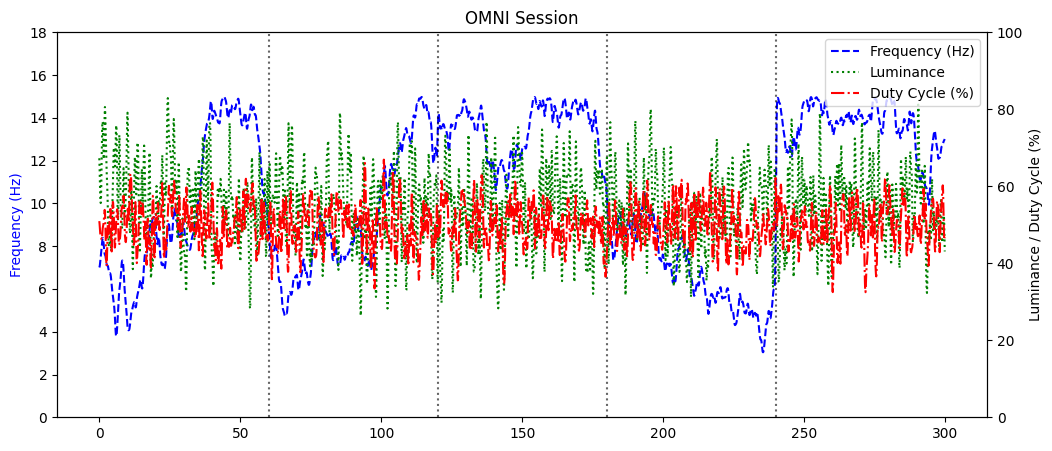

OMNI session generated, saved, and plotted successfully.


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ===========================
# Load Session Data
# ===========================
session_types = ["HG", "OM", "DP", "CE", "RE"]
stp_dir = "stp_sessions"

# Load all session TXT files from stp_sessions/
sessions = {}

for name in session_types:
    session_path = f"{stp_dir}/{name}.txt"

    with open(session_path, "r", encoding="utf-8") as f:
        lines = f.readlines()[2:]  # Skip first two header lines (TIM and DUR)

    # Parse STP-formatted data
    data = []
    for line in lines:
        line = line.strip().replace('STP"', '')  # Remove "STP" prefix
        values = line.split(",")  # Split on commas
        values = [v.strip().replace('"', '') for v in values]  # Remove quotes
        data.append([float(v) for v in values])  # Convert to float

    # Convert to DataFrame
    num_columns = len(data[0])  # Detect number of columns dynamically
    column_names = [
        "Step Duration", "Wave Type", "Start Freq", "End Freq",
        "Start Duty", "End Duty", "LED1", "LED2", "LED3", "LED4",
        "Start Lum", "End Lum"
    ]

    # If additional oscillators are present, dynamically add columns
    if num_columns > len(column_names):
        additional_columns = [f"OSC{i}" for i in range(1, num_columns - len(column_names) + 1)]
        column_names.extend(additional_columns)

    df = pd.DataFrame(data, columns=column_names)

    # Assign Time column based on cumulative duration
    df["Time (s)"] = np.arange(0, len(df) * 0.1, 0.1)[:len(df)]
    sessions[name] = df

# ===========================
# Generate OMNI Session (Segmented)
# ===========================
def generate_omni_session(sessions):
    """
    Creates an 'OMNI' session by sequentially combining 60-second chunks
    from each session type while preserving their unique variability.
    These time points are manually selected given their characteristics
    to attempt to provide a gradual onset and decay with some jittered
    periods before a central peak of exponential growth. Should you
    desire different segments based on the characteristics of the
    individual sessions, simply replace these segments with different
    numbers, and then adjust the value of continuous_time dynamically.
    (As it stands now, it's ideal of each segment contributes to the
    overall duration equally.)
    """
    session_segments = {
        "HG": (0, 60),
        "OM": (60, 120),
        "DP": (120, 180),
        "CE": (180, 240),
        "RE": (240, 300)
    }

    omni_chunks = []
    cumulative_time = 0  # Keeps track of total session time

    for mode, (start_time, end_time) in session_segments.items():
        df = sessions[mode]

        # Select rows that fall within the time range
        chunk = df[(df["Time (s)"] >= start_time) & (df["Time (s)"] < end_time)].copy()

        # Adjust time to be continuous
        chunk["Time (s)"] = np.arange(cumulative_time, cumulative_time + len(chunk) * 0.1, 0.1)[:len(chunk)]
        cumulative_time += 60  # Each segment contributes exactly 60 seconds; adjust as needed

        # Ensure start values match their end values within the same STP step
        chunk["End Freq"] = chunk["Start Freq"]
        chunk["End Duty"] = chunk["Start Duty"]
        chunk["End Lum"] = chunk["Start Lum"]

        omni_chunks.append(chunk)

    # Concatenate all chunks in order
    omni_df = pd.concat(omni_chunks, ignore_index=True)

    return omni_df

omni_session = generate_omni_session(sessions)

# ===========================
# Convert OMNI to STP Format
# ===========================
def format_strobe_sequence(df, wave_type):
    """Formats DataFrame into STP format while preserving interpolation & rounding values appropriately."""
    output = []
    session_duration = df["Time (s)"].max()
    output.append(f'TIM"00:00:{session_duration:.1f}"')
    output.append(f'DUR"{session_duration:.1f}"')

    for i in range(len(df) - 1):
        step_duration = 0.1  # Fixed step duration
        start_freq = df.loc[i, "Start Freq"]
        end_freq = df.loc[i, "End Freq"]  # Keep the same as Start Freq for matching
        start_d = round(df.loc[i, "Start Duty"])  # Ensure integer rounding
        end_d = start_d  # Ensure End Duty = Start Duty
        start_l = round(df.loc[i, "Start Lum"])  # Ensure integer rounding
        end_l = start_l  # Ensure End Lum = Start Lum

        # Extract additional oscillators if they exist
        additional_oscillators = ""
        if "OSC1" in df.columns:
            additional_oscillators = ",".join([str(int(df.loc[i, col])) for col in df.columns if col.startswith("OSC")])

        stp_line = (
            f'STP"{step_duration:.1f},{wave_type},'
            f'{start_freq:.2f},{end_freq:.2f},'
            f'{start_d},{end_d},'
            f'1,1,1,1,'  # Main oscillator ON, others OFF since we're pulling this from individual sessions
            f'{start_l},{end_l},'
            f'{additional_oscillators}"' if additional_oscillators else f'{start_l},{end_l}"'
        )
        output.append(stp_line)

    return "\r\n".join(output)  # Use CRLF line endings

# Save OMNI session as TXT in STP format
wave_type = 1  # Default to Square wave for OMNI
strobe_data = format_strobe_sequence(omni_session, wave_type)
omni_filename = f"{stp_dir}/OMNI.txt"

with open(omni_filename, "w", encoding="utf-8") as f:
    f.write(strobe_data)

print(f"OMNI session saved: {omni_filename}")

# ===========================
# Apply Smoothing for Visualization
# ===========================
smoothing_sigma = 2
smoothed_freq = gaussian_filter1d(omni_session["Start Freq"], sigma=smoothing_sigma)
smoothed_lum = gaussian_filter1d(omni_session["Start Lum"], sigma=smoothing_sigma)
smoothed_duty = gaussian_filter1d(omni_session["Start Duty"], sigma=smoothing_sigma)

# ===========================
# Plot OMNI Session
# ===========================
fig, ax = plt.subplots(figsize=(12, 5))
ax2 = ax.twinx()

# Plot Smoothed Frequency
ax.plot(omni_session["Time (s)"], smoothed_freq, linestyle="dashed", color="blue", label="Frequency (Hz)")
ax.set_ylim(0, 18)

# Plot Smoothed Luminance and Duty Cycle
ax2.plot(omni_session["Time (s)"], smoothed_lum, linestyle="dotted", color="green", label="Luminance")
ax2.plot(omni_session["Time (s)"], smoothed_duty, linestyle="dashdot", color="red", label="Duty Cycle (%)")
ax2.set_ylim(0, 100)

# Add vertical markers to show session transitions
for transition_time in [60, 120, 180, 240]:
    ax.axvline(x=transition_time, color="black", linestyle="dotted", alpha=0.6)

# Labels and Titles
ax.set_ylabel("Frequency (Hz)", color="blue")
ax2.set_ylabel("Luminance / Duty Cycle (%)", color="black")
ax.set_title("OMNI Session")

# Legend handling
ax_lines, ax_labels = ax.get_legend_handles_labels()
ax2_lines, ax2_labels = ax2.get_legend_handles_labels()
ax2.legend(ax_lines + ax2_lines, ax_labels + ax2_labels, loc="upper right")

plt.xlabel("Time (s)")
plt.show()

print("OMNI session generated, saved, and plotted successfully.")

3. 5 Individual Square-Wave Sessions with Gaussian Enveloping

While the initial sequences were generated stochastically, and then had explicit segments specified to be appended into an omni sequence, it doesn't allow much graduation in the sequence; so, we can try and edit our initial logic to shuffle things a bit to follow normal distributions by applying a Gaussian envelope to all of our parameters.

Session files generated and saved.


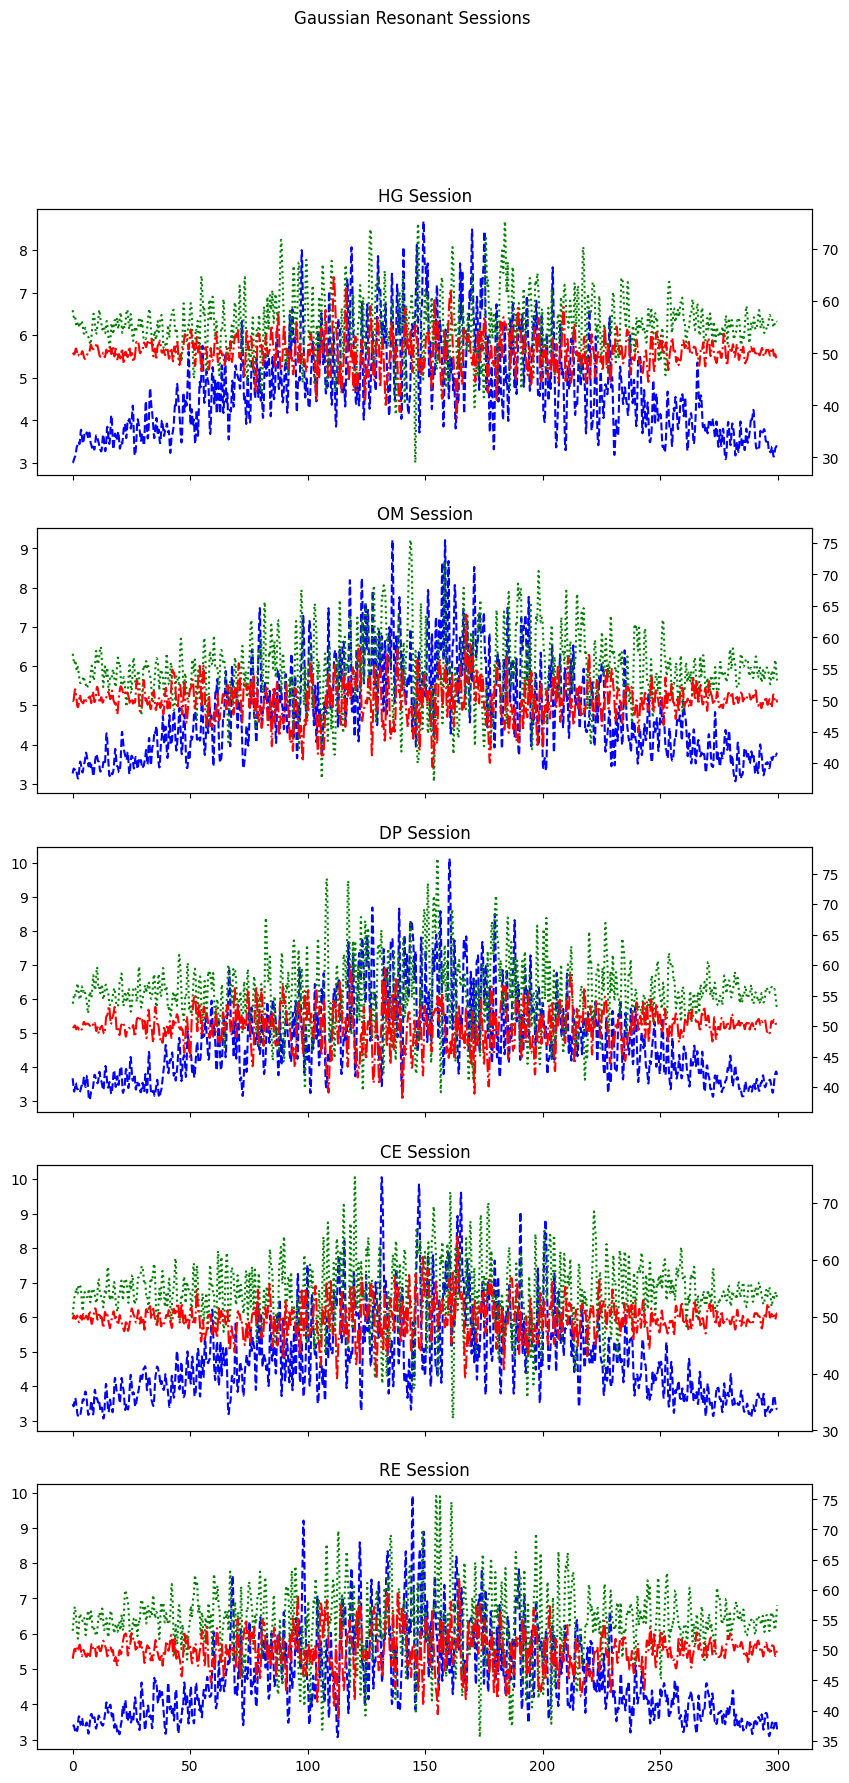

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ===========================
# Session Parameters
# ===========================
session_duration = 300  # 5 minutes (300 seconds)
time_step = 0.1  # 0.1s resolution
num_steps = int(session_duration / time_step)

# Parameter constraints
frequency_range = (3, 15)  # Hz
luminance_range = (10, 100)  # Arbitrary units (Integers)
duty_cycle_range = (25, 75)  # Percentage (Integers)
smoothing_sigma = 3  # Used for visualization only!

# ===========================
# Directory Setup
# ===========================
output_dir = "session_data"
stp_dir = "stp_sessions"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(stp_dir, exist_ok=True)

# ===========================
# Generate Gaussian Envelope
# ===========================
def generate_gaussian_envelope():
    """Generate a Gaussian envelope that modulates session parameters smoothly."""
    time = np.linspace(0, session_duration, num_steps)[:-1]  # Ensure length matches data
    midpoint = session_duration / 2
    sigma = session_duration / 4  # Spread factor

    envelope = np.exp(-((time - midpoint) ** 2) / (2 * sigma ** 2))
    return envelope / envelope.max()  # Normalize to peak at 1.0

# Generate the envelope (after sequences are generated)
gaussian_envelope = generate_gaussian_envelope()

# ===========================
# Modulation Functions
# ===========================
def modulate_frequency(prev_freq, progress, mode):
    """Generate frequency variation dynamically before applying the envelope."""
    if mode == "harmonic_glide":
        freq = 3 + (12 * progress) + np.random.uniform(-0.5, 0.5)
    elif mode == "oscillatory_mode":
        freq = 9 + 3 * np.sin(2 * np.pi * progress) + np.random.uniform(-0.2, 0.2)
    elif mode == "divergent_pattern":
        freq = prev_freq * (1 + np.random.uniform(-0.1, 0.1))
    elif mode == "chirped_excitation":
        freq = 3 + (10 * (progress ** 1.5)) + np.random.uniform(-0.3, 0.3)
    elif mode == "randomized_exploration":
        freq = np.random.uniform(*frequency_range)
    else:
        freq = prev_freq + np.random.uniform(-0.5, 0.5)

    return np.clip(freq, *frequency_range)

def modulate_luminance(progress, prev_lum, mode):
    """Generate luminance variation dynamically before applying the envelope."""
    if mode == "harmonic_glide":
        target = 20 + (80 * np.sin(progress * np.pi * 0.5)) + np.random.randint(-5, 6)
    elif mode == "oscillatory_mode":
        target = 10 + (90 * (0.5 + 0.5 * np.sin(6 * np.pi * progress))) + np.random.randint(-8, 9)
    elif mode == "divergent_pattern":
        target = np.random.randint(10, 101) if np.random.rand() < 0.3 else prev_lum + np.random.randint(-20, 21)
    elif mode == "chirped_excitation":
        target = 10 + (90 * (progress ** 1.4)) + np.random.randint(-5, 6)
    elif mode == "randomized_exploration":
        target = np.random.randint(10, 101)
    else:
        target = np.random.randint(10, 101)

    return int(np.clip(target, *luminance_range))

def modulate_duty_cycle(progress, prev_duty, mode):
    """Generate duty cycle variation dynamically before applying the envelope."""
    if mode == "harmonic_glide":
        target = 30 + (40 * np.sin(progress * np.pi * 0.5)) + np.random.randint(-3, 4)
    elif mode == "oscillatory_mode":
        target = 25 + (50 * (0.5 + 0.5 * np.sin(8 * np.pi * progress))) + np.random.randint(-6, 7)
    elif mode == "divergent_pattern":
        target = np.random.randint(25, 76) if np.random.rand() < 0.3 else prev_duty + np.random.randint(-15, 16)
    elif mode == "chirped_excitation":
        target = 25 + (50 * (progress ** 1.3)) + np.random.randint(-5, 6)
    elif mode == "randomized_exploration":
        target = np.random.randint(25, 76)
    else:
        target = np.random.randint(25, 76)

    return int(np.clip(target, *duty_cycle_range))

# ===========================
# Generate Sessions First
# ===========================
def generate_sequence(mode):
    """Generate session data based on mode-specific modulation before applying the envelope."""
    time = np.arange(0, session_duration, time_step)[:-1]

    frequency = np.array([modulate_frequency(frequency_range[0], i/num_steps, mode) for i in range(len(time))])
    luminance = np.array([modulate_luminance(i/num_steps, luminance_range[0], mode) for i in range(len(time))])
    duty_cycle = np.array([modulate_duty_cycle(i/num_steps, duty_cycle_range[0], mode) for i in range(len(time))])

    return pd.DataFrame({
        "Time (s)": time,
        "Start Freq": frequency,
        "End Freq": frequency,
        "Start Lum": luminance,
        "End Lum": luminance,
        "Start Duty": duty_cycle,
        "End Duty": duty_cycle
    })

session_types = ["HG", "OM", "DP", "CE", "RE"]
base_sequences = {name: generate_sequence(name.lower()) for name in session_types}

# ===========================
# Apply Envelope After Generating Sessions
# ===========================
def apply_envelope(data, is_frequency=False):
    """
    Apply Gaussian envelope while preserving the full range of values.
    - **For frequency**, scale the full 3-15 Hz range directly.
    - **For luminance/duty cycle**, keep their Gaussian transitions.
    """
    min_val, max_val = np.min(data), np.max(data)

    if is_frequency:
        # Ensure full range utilization (3-15 Hz)
        data_scaled = (data - min_val) / (max_val - min_val)  # Normalize to [0,1]
        data_scaled = 3 + (12 * gaussian_envelope * data_scaled)  # Scale within 3-15 Hz
        return np.clip(data_scaled, 3, 15)  # Ensure valid range

    else:
        # Apply Gaussian envelope normally for luminance/duty cycle
        baseline = np.mean(data)
        deviation = data - baseline
        return np.clip(baseline + deviation * gaussian_envelope, min_val, max_val)

for mode in session_types:
    base_sequences[mode]["Start Freq"] = apply_envelope(base_sequences[mode]["Start Freq"], is_frequency=True)
    base_sequences[mode]["End Freq"] = base_sequences[mode]["Start Freq"]  # Ensure consistency

    base_sequences[mode]["Start Lum"] = apply_envelope(base_sequences[mode]["Start Lum"], is_frequency=False)
    base_sequences[mode]["End Lum"] = base_sequences[mode]["Start Lum"]

    base_sequences[mode]["Start Duty"] = apply_envelope(base_sequences[mode]["Start Duty"], is_frequency=False)
    base_sequences[mode]["End Duty"] = base_sequences[mode]["Start Duty"]

# ===========================
# Convert to STP Format & Save as .txt (With Extra Oscillators)
# ===========================

def format_strobe_sequence(df, wave_type):
    """Formats DataFrame into STP format, ensuring extra oscillators are present but disabled."""
    output = []
    output.append(f'TIM"00:00:{session_duration:.1f}"')
    output.append(f'DUR"{session_duration:.1f}"')

    for i in range(len(df)):
        stp_line = f'STP"{time_step:.1f},{wave_type},' \
                   f'{df.loc[i, "Start Freq"]:.2f},{df.loc[i, "End Freq"]:.2f},' \
                   f'{df.loc[i, "Start Duty"]},{df.loc[i, "End Duty"]},' \
                   f'1,1,1,1,' \
                   f'{df.loc[i, "Start Lum"]},{df.loc[i, "End Lum"]},' \
                   f'0,{df.loc[i, "Start Freq"]:.2f},{df.loc[i, "End Freq"]:.2f},0,0,0,0,0,0,0,' \
                   f'0,{df.loc[i, "Start Freq"]:.2f},{df.loc[i, "End Freq"]:.2f},0,0,0,0,0,0,0,' \
                   f'0,{df.loc[i, "Start Freq"]:.2f},{df.loc[i, "End Freq"]:.2f},0,0,0,0,0,0,0"'

        output.append(stp_line)

    return "\r\n".join(output)

for mode, df in base_sequences.items():
    wave_type = 1
    strobe_data = format_strobe_sequence(df, wave_type)
    with open(f"{stp_dir}/{mode}.txt", "w", encoding="utf-8") as f:
        f.write(strobe_data)

print("Session files generated and saved.")

# ===========================
# Plot Results
# ===========================
fig, axes = plt.subplots(len(session_types), 1, figsize=(10, 20), sharex=True)

for ax, (mode, df) in zip(axes, base_sequences.items()):
    ax2 = ax.twinx()

    smoothed_freq = gaussian_filter1d(df["Start Freq"], sigma=smoothing_sigma)
    smoothed_lum = gaussian_filter1d(df["Start Lum"], sigma=smoothing_sigma)
    smoothed_duty = gaussian_filter1d(df["Start Duty"], sigma=smoothing_sigma)

    ax.plot(df["Time (s)"], smoothed_freq, linestyle="dashed", color="blue", label="Frequency (Hz)")
    ax2.plot(df["Time (s)"], smoothed_lum, linestyle="dotted", color="green", label="Luminance")
    ax2.plot(df["Time (s)"], smoothed_duty, linestyle="dashdot", color="red", label="Duty Cycle (%)")

    ax.set_title(f"{mode} Session")

plt.suptitle("Gaussian Resonant Sessions")
plt.show()

4. Gaussian Omni-Session, Comprised of Explicitly-Defined Segments from Smoothed Sessions Generated from Script 3

OMNI session saved: stp_sessions/OMNI.txt


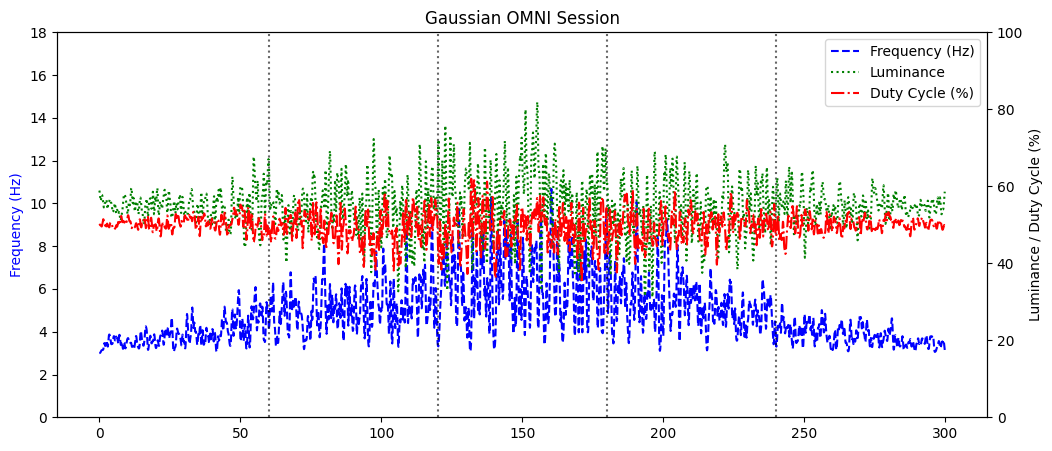

OMNI session generated, saved, and plotted successfully.


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ===========================
# Load Session Data
# ===========================
session_types = ["HG", "OM", "DP", "CE", "RE"]
stp_dir = "stp_sessions"

# Load all session TXT files from stp_sessions/
sessions = {}

for name in session_types:
    session_path = f"{stp_dir}/{name}.txt"

    with open(session_path, "r", encoding="utf-8") as f:
        lines = f.readlines()[2:]  # Skip first two header lines (TIM and DUR)

    # Parse STP-formatted data
    data = []
    for line in lines:
        line = line.strip().replace('STP"', '')  # Remove "STP" prefix
        values = line.split(",")  # Split on commas
        values = [v.strip().replace('"', '') for v in values]  # Remove quotes
        data.append([float(v) for v in values])  # Convert to float

    # Convert to DataFrame
    num_columns = len(data[0])  # Detect number of columns dynamically
    column_names = [
        "Step Duration", "Wave Type", "Start Freq", "End Freq",
        "Start Duty", "End Duty", "LED1", "LED2", "LED3", "LED4",
        "Start Lum", "End Lum"
    ]

    # If additional oscillators are present, dynamically add columns
    if num_columns > len(column_names):
        additional_columns = [f"OSC{i}" for i in range(1, num_columns - len(column_names) + 1)]
        column_names.extend(additional_columns)

    df = pd.DataFrame(data, columns=column_names)

    # Assign Time column based on cumulative duration
    df["Time (s)"] = np.arange(0, len(df) * 0.1, 0.1)[:len(df)]
    sessions[name] = df

# ===========================
# Generate OMNI Session (Segmented)
# ===========================
def generate_omni_session(sessions):
    """
    Creates an 'OMNI' session by sequentially combining 60-second chunks
    from each session type while preserving their unique variability.
    These time points are manually selected given their characteristics
    to attempt to provide a gradual onset and decay with some jittered
    periods before a central peak of exponential growth. Should you
    desire different segments based on the characteristics of the
    individual sessions, simply replace these segments with different
    numbers, and then adjust the value of continuous_time dynamically.
    (As it stands now, it's ideal of each segment contributes to the
    overall duration equally.)
    """
    session_segments = {
        "HG": (0, 60),
        "OM": (60, 120),
        "DP": (120, 180),
        "CE": (180, 240),
        "RE": (240, 300)
    }

    omni_chunks = []
    cumulative_time = 0  # Keeps track of total session time

    for mode, (start_time, end_time) in session_segments.items():
        df = sessions[mode]

        # Select rows that fall within the time range
        chunk = df[(df["Time (s)"] >= start_time) & (df["Time (s)"] < end_time)].copy()

        # Adjust time to be continuous
        chunk["Time (s)"] = np.arange(cumulative_time, cumulative_time + len(chunk) * 0.1, 0.1)[:len(chunk)]
        cumulative_time += 60  # Each segment contributes exactly 60 seconds; adjust as needed

        # Ensure start values match their end values within the same STP step
        chunk["End Freq"] = chunk["Start Freq"]
        chunk["End Duty"] = chunk["Start Duty"]
        chunk["End Lum"] = chunk["Start Lum"]

        omni_chunks.append(chunk)

    # Concatenate all chunks in order
    omni_df = pd.concat(omni_chunks, ignore_index=True)

    return omni_df

omni_session = generate_omni_session(sessions)

# ===========================
# Convert OMNI to STP Format
# ===========================
def format_strobe_sequence(df, wave_type):
    """Formats DataFrame into STP format while preserving interpolation & rounding values appropriately."""
    output = []
    session_duration = df["Time (s)"].max()
    output.append(f'TIM"00:00:{session_duration:.1f}"')
    output.append(f'DUR"{session_duration:.1f}"')

    for i in range(len(df) - 1):
        step_duration = 0.1  # Fixed step duration
        start_freq = df.loc[i, "Start Freq"]
        end_freq = df.loc[i, "End Freq"]  # Keep the same as Start Freq for matching
        start_d = round(df.loc[i, "Start Duty"])  # Ensure integer rounding
        end_d = start_d  # Ensure End Duty = Start Duty
        start_l = round(df.loc[i, "Start Lum"])  # Ensure integer rounding
        end_l = start_l  # Ensure End Lum = Start Lum

        # Extract additional oscillators if they exist
        additional_oscillators = ""
        if "OSC1" in df.columns:
            additional_oscillators = ",".join([str(int(df.loc[i, col])) for col in df.columns if col.startswith("OSC")])

        stp_line = (
            f'STP"{step_duration:.1f},{wave_type},'
            f'{start_freq:.2f},{end_freq:.2f},'
            f'{start_d},{end_d},'
            f'1,1,1,1,'  # Main oscillator ON, others OFF
            f'{start_l},{end_l},'
            f'{additional_oscillators}"' if additional_oscillators else f'{start_l},{end_l}"'
        )
        output.append(stp_line)

    return "\r\n".join(output)  # Use CRLF line endings

# Save OMNI session as TXT in STP format
wave_type = 1  # Default to Square wave for OMNI
strobe_data = format_strobe_sequence(omni_session, wave_type)
omni_filename = f"{stp_dir}/OMNI.txt"

with open(omni_filename, "w", encoding="utf-8") as f:
    f.write(strobe_data)

print(f"OMNI session saved: {omni_filename}")

# ===========================
# Apply Smoothing for Visualization
# ===========================
smoothing_sigma = 2
smoothed_freq = gaussian_filter1d(omni_session["Start Freq"], sigma=smoothing_sigma)
smoothed_lum = gaussian_filter1d(omni_session["Start Lum"], sigma=smoothing_sigma)
smoothed_duty = gaussian_filter1d(omni_session["Start Duty"], sigma=smoothing_sigma)

# ===========================
# Plot OMNI Session
# ===========================
fig, ax = plt.subplots(figsize=(12, 5))
ax2 = ax.twinx()

# Plot Smoothed Frequency
ax.plot(omni_session["Time (s)"], smoothed_freq, linestyle="dashed", color="blue", label="Frequency (Hz)")
ax.set_ylim(0, 18)

# Plot Smoothed Luminance and Duty Cycle
ax2.plot(omni_session["Time (s)"], smoothed_lum, linestyle="dotted", color="green", label="Luminance")
ax2.plot(omni_session["Time (s)"], smoothed_duty, linestyle="dashdot", color="red", label="Duty Cycle (%)")
ax2.set_ylim(0, 100)

# Add vertical markers to show session transitions
for transition_time in [60, 120, 180, 240]:
    ax.axvline(x=transition_time, color="black", linestyle="dotted", alpha=0.6)

# Labels and Titles
ax.set_ylabel("Frequency (Hz)", color="blue")
ax2.set_ylabel("Luminance / Duty Cycle (%)", color="black")
ax.set_title("Gaussian OMNI Session")

# Legend handling
ax_lines, ax_labels = ax.get_legend_handles_labels()
ax2_lines, ax2_labels = ax2.get_legend_handles_labels()
ax2.legend(ax_lines + ax2_lines, ax_labels + ax2_labels, loc="upper right")

plt.xlabel("Time (s)")
plt.show()

print("OMNI session generated, saved, and plotted successfully.")

The final version of this code allows for the user to specify dwell time and envelope application.

5. 5 Individual Square-Wave Sessions, with User-Input Defined Session Length, Step Duration, and Gaussian Envelope Application

Enter session duration in seconds (e.g., 300 for 5 minutes): 300
Enter time step (e.g., 0.1 for high resolution, 0.5+ for longer steps): 3
Apply Gaussian envelope? (yes/no): yes
Session files generated and saved.


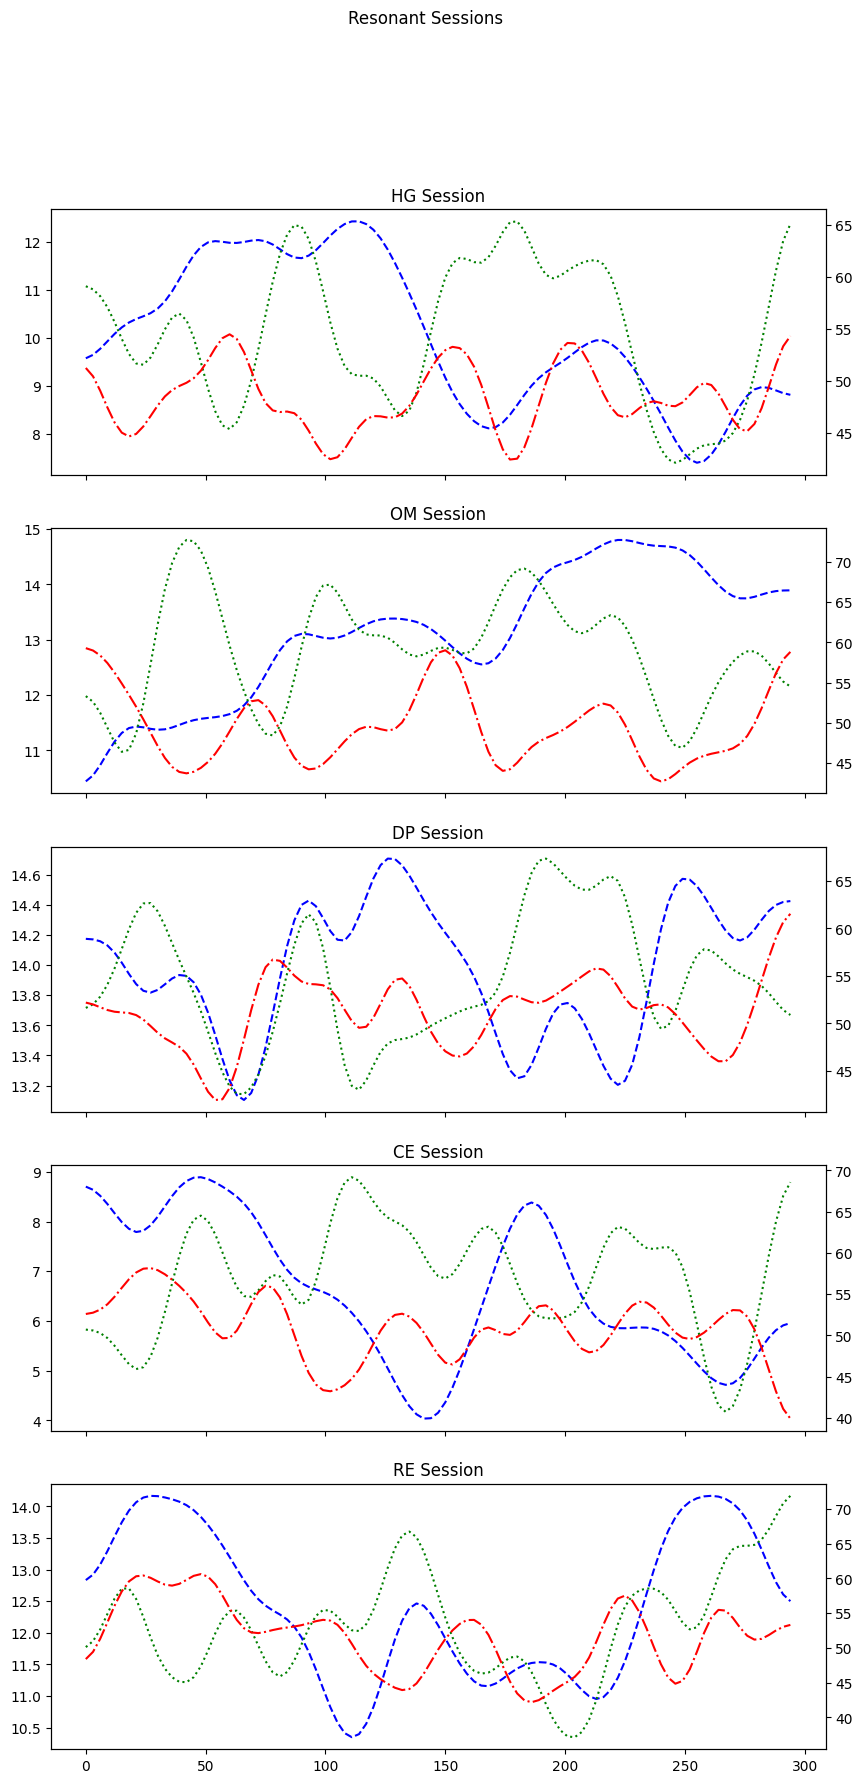

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ===========================
# User Input Parameters
# ===========================
# User input for session duration
session_duration = float(input("Enter session duration in seconds (e.g., 300 for 5 minutes): "))

# User input for time step (affects granularity & duration per STP command)
time_step = float(input("Enter time step (e.g., 0.1 for high resolution, 0.5+ for longer steps): "))

# User input for Gaussian envelope application
apply_envelope_flag = input("Apply Gaussian envelope? (yes/no): ").strip().lower() == "yes"

# ===========================
# Derived Parameters
# ===========================
num_steps = int(session_duration / time_step)  # Total number of steps

# Parameter constraints
frequency_range = (3, 15)  # Hz
luminance_range = (10, 100)  # Arbitrary units (Integers)
duty_cycle_range = (25, 75)  # Percentage (Integers)

smoothing_sigma = 3  # Used for visualization only

# ===========================
# Directory Setup
# ===========================
output_dir = "session_data"
stp_dir = "stp_sessions"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(stp_dir, exist_ok=True)

# ===========================
# Generate Gaussian Envelope
# ===========================
def generate_gaussian_envelope():
    """Generate a Gaussian envelope that modulates session parameters smoothly."""
    time = np.linspace(0, session_duration, num_steps)[:-1]  # Ensure length matches data
    midpoint = session_duration / 2
    sigma = session_duration / 4  # Spread factor

    envelope = np.exp(-((time - midpoint) ** 2) / (2 * sigma ** 2))
    return envelope / envelope.max()  # Normalize to peak at 1.0

# Generate the envelope only if enabled
if apply_envelope_flag:
    gaussian_envelope = generate_gaussian_envelope()

# ===========================
# Modulation Functions
# ===========================
def modulate_frequency(prev_freq, progress, mode):
    """Generate frequency variation dynamically ensuring full range utilization."""
    if mode == "harmonic_glide":
        freq = prev_freq + np.random.uniform(-1.0, 1.0) + (12 * progress)
    elif mode == "oscillatory_mode":
        freq = prev_freq + np.random.uniform(-0.5, 0.5) + 3 * np.sin(2 * np.pi * progress)
    elif mode == "divergent_pattern":
        freq = prev_freq * (1 + np.random.uniform(-0.15, 0.15))
    elif mode == "chirped_excitation":
        freq = 3 + (10 * (progress ** 1.5)) + np.random.uniform(-0.5, 0.5)
    elif mode == "randomized_exploration":
        freq = np.random.uniform(*frequency_range)
    else:
        freq = prev_freq + np.random.uniform(-1.0, 1.0)

    return np.clip(freq, *frequency_range)

def modulate_luminance(progress, prev_lum, mode):
    """Generate luminance variation dynamically before applying the envelope."""
    if mode == "harmonic_glide":
        target = 20 + (80 * np.sin(progress * np.pi * 0.5)) + np.random.randint(-5, 6)
    elif mode == "oscillatory_mode":
        target = 10 + (90 * (0.5 + 0.5 * np.sin(6 * np.pi * progress))) + np.random.randint(-8, 9)
    elif mode == "divergent_pattern":
        target = np.random.randint(10, 101) if np.random.rand() < 0.3 else prev_lum + np.random.randint(-20, 21)
    elif mode == "chirped_excitation":
        target = 10 + (90 * (progress ** 1.4)) + np.random.randint(-5, 6)
    elif mode == "randomized_exploration":
        target = np.random.randint(10, 101)
    else:
        target = np.random.randint(10, 101)

    return int(np.clip(target, *luminance_range))

def modulate_duty_cycle(progress, prev_duty, mode):
    """Generate duty cycle variation dynamically before applying the envelope."""
    if mode == "harmonic_glide":
        target = 30 + (40 * np.sin(progress * np.pi * 0.5)) + np.random.randint(-3, 4)
    elif mode == "oscillatory_mode":
        target = 25 + (50 * (0.5 + 0.5 * np.sin(8 * np.pi * progress))) + np.random.randint(-6, 7)
    elif mode == "divergent_pattern":
        target = np.random.randint(25, 76) if np.random.rand() < 0.3 else prev_duty + np.random.randint(-15, 16)
    elif mode == "chirped_excitation":
        target = 25 + (50 * (progress ** 1.3)) + np.random.randint(-5, 6)
    elif mode == "randomized_exploration":
        target = np.random.randint(25, 76)
    else:
        target = np.random.randint(25, 76)

    return int(np.clip(target, *duty_cycle_range))

# ===========================
# Generate Sessions First
# ===========================
def generate_sequence(mode):
    """Generate session data based on mode-specific modulation before applying the envelope."""
    time = np.arange(0, session_duration, time_step)[:-1]

    frequency = np.zeros(len(time))
    luminance = np.zeros(len(time))
    duty_cycle = np.zeros(len(time))

    frequency[0] = np.random.uniform(*frequency_range)
    luminance[0] = np.random.randint(*luminance_range)
    duty_cycle[0] = np.random.randint(*duty_cycle_range)

    for i in range(1, len(time)):
        progress = i / len(time)
        frequency[i] = modulate_frequency(frequency[i - 1], progress, mode)
        luminance[i] = modulate_luminance(progress, luminance[i - 1], mode)
        duty_cycle[i] = modulate_duty_cycle(progress, duty_cycle[i - 1], mode)

    return pd.DataFrame({
        "Time (s)": time,
        "Start Freq": frequency,
        "End Freq": frequency,
        "Start Lum": luminance,
        "End Lum": luminance,
        "Start Duty": duty_cycle,
        "End Duty": duty_cycle
    })

session_types = ["HG", "OM", "DP", "CE", "RE"]
base_sequences = {name: generate_sequence(name.lower()) for name in session_types}

# ===========================
# Convert to STP Format & Save as .txt (With Extra Oscillators)
# ===========================

def format_strobe_sequence(df, wave_type):
    """Formats DataFrame into STP format, ensuring extra oscillators are present but disabled."""
    output = []
    output.append(f'TIM"00:00:{session_duration:.1f}"')
    output.append(f'DUR"{session_duration:.1f}"')

    for i in range(len(df)):
        stp_line = f'STP"{time_step:.1f},{wave_type},' \
                   f'{df.loc[i, "Start Freq"]:.2f},{df.loc[i, "End Freq"]:.2f},' \
                   f'{df.loc[i, "Start Duty"]},{df.loc[i, "End Duty"]},' \
                   f'1,1,1,1,' \
                   f'{df.loc[i, "Start Lum"]},{df.loc[i, "End Lum"]},' \
                   f'0,{df.loc[i, "Start Freq"]:.2f},{df.loc[i, "End Freq"]:.2f},0,0,0,0,0,0,0,' \
                   f'0,{df.loc[i, "Start Freq"]:.2f},{df.loc[i, "End Freq"]:.2f},0,0,0,0,0,0,0,' \
                   f'0,{df.loc[i, "Start Freq"]:.2f},{df.loc[i, "End Freq"]:.2f},0,0,0,0,0,0,0"'

        output.append(stp_line)

    return "\r\n".join(output)

for mode, df in base_sequences.items():
    wave_type = 1
    strobe_data = format_strobe_sequence(df, wave_type)
    with open(f"{stp_dir}/{mode}.txt", "w", encoding="utf-8") as f:
        f.write(strobe_data)

print("Session files generated and saved.")

# ===========================
#  Corrected Plotting Code
# ===========================
fig, axes = plt.subplots(len(session_types), 1, figsize=(10, 20), sharex=True)

for ax, (mode, df) in zip(axes, base_sequences.items()):
    ax2 = ax.twinx()

    smoothed_freq = gaussian_filter1d(df["Start Freq"], sigma=smoothing_sigma)
    smoothed_lum = gaussian_filter1d(df["Start Lum"], sigma=smoothing_sigma)
    smoothed_duty = gaussian_filter1d(df["Start Duty"], sigma=smoothing_sigma)

    ax.plot(df["Time (s)"], smoothed_freq, linestyle="dashed", color="blue", label="Frequency (Hz)")
    ax2.plot(df["Time (s)"], smoothed_lum, linestyle="dotted", color="green", label="Luminance")
    ax2.plot(df["Time (s)"], smoothed_duty, linestyle="dashdot", color="red", label="Duty Cycle (%)")

    ax.set_title(f"{mode} Session")

plt.suptitle("Resonant Sessions")
plt.show()